# Get timeseries of F0s
- Measures every 10 ms
- Needs to be extended to multiple wav files
- Need to add filename somehow as a feature, to keep track

In [1]:
import os
from Tkinter import *
import tkSnack
import pandas as pd
root = Tk()
tkSnack.initializeSnack(root)

from sklearn.externals.joblib import Memory
memory = Memory(cachedir="cache")

In [2]:
##from pylab import *


@memory.cache
def getSound(fname_list):
    pitch_list = []
    for item in fname_list:
        utterance = tkSnack.Sound()
        utterance.read(item)
        utterance.convert(channels=1)
        pitch_tuple = utterance.pitch(method="ESPS", windowlength = 0.010)
        pitch_list.append(pitch_tuple)
        utterance.destroy()
    return pitch_list



path = "c:/Python27/qp2_py/small_for_test/"
#path = "c:/Python27/qp2_py/data/"
allFiles = os.listdir(path)
allTxtgridsCOMB = [item for item in allFiles if item[0]== "C"]
allWavs = [item for item in allFiles if item[0] !="C"]

allPaths = []
for item in allWavs:
    total_path = path+item
    allPaths.append(total_path)

allTxtgrids = []
allTxtPaths = []
for item in allTxtgridsCOMB:
    outlist = item.split('COMBINE_')
    name = outlist[1]
    allTxtgrids.append(name)
    allTxtPaths.append(path+name)

    
allTxtgrids.sort()
allWavs.sort()


#fname = [non_fname, native_fname]
pitch_list = getSound(allPaths)

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-Rachel-Documents-Grad_Stuff-QP2-code-__ipython-input__.getSound-alias...
getSound-alias([ 'c:/Python27/qp2_py/small_for_test/p204p205-part1_ch1.wav',
  'c:/Python27/qp2_py/small_for_test/p204p205-part1_ch2.wav',
  'c:/Python27/qp2_py/small_for_test/p206p207-part1_ch1.wav',
  'c:/Python27/qp2_py/small_for_test/p206p207-part1_ch2.wav',
  'c:/Python27/qp2_py/small_for_test/p208p209-part1_ch1.wav',
  'c:/Python27/qp2_py/small_for_test/p208p209-part1_ch2.wav',
  'c:/Python27/qp2_py/small_for_test/p264p265-part1_ch1.wav',
  'c:/Python27/qp2_py/small_for_test/p386p387-part1_ch2.wav',
  'c:/Python27/qp2_py/small_for_test/p416p417-part1_ch1.wav',
  'c:/Python27/qp2_py/small_for_test/p416p417-part1_ch2.wav'])
_________________________________________________getSound-alias - 197.1s, 3.3min


In [3]:
print len(pitch_list)

10


### Gets all of the F0 points

In [3]:
### Make a list of lists of F0 points

all_f0s_list = []
for item in pitch_list:
    just_f0_list = [j[0] for j in item]
    all_f0s_list.append(just_f0_list)


    
print len(all_f0s_list)
for i in all_f0s_list:
    print len(i)

## output is [[series of f0s for one file][series of f0s for next file]] etc 




10
286482
286482
28647
28647
201996
201996
114408
107447
76590
76590


## Make TextGrid Objects
- Edit THIS CODE if you want to look at tiers other than IPU tiers (like Question Tiers)

In [4]:

import tgt
#non_txtgrd = "c:/Python27/qp2_py/txtgrids/COMBINE_p452p453-part2_ch1.textgrid"
#native_txtgrd = "c:/Python27/qp2_py/txtgrids/p226p227-part2_ch2.textgrid"
#all_txtgrids = [non_txtgrd, native_txtgrd]

allTxtPaths = []
path = "c:/Python27/qp2_py/small_for_test/"
for item in allTxtgridsCOMB:
    allTxtPaths.append(path+item)


checkGrid = allTxtPaths[0]


In [5]:
grid_obj= tgt.read_textgrid(checkGrid)
grid_obj.get_tier_names()


[u'BF', u'WORD', u'LONG_WORD', u'LONG_IPUs', u'IPU_WORDs', u'LAUGHTER']

## Combines TextGrids with F0s
- This works now

In [6]:
#annotations are a list of interval objects
inter = []
segmented_f0s = []

for i in range(len(allTxtPaths)):
    grid_obj = tgt.read_textgrid(allTxtPaths[i])
    word = grid_obj.get_tier_by_name('IPU_WORDs')
    ipus = word.annotations
    print len(ipus)
    length = len(ipus)
    for j in range(length):
        start = ipus[j].start_time
        end = ipus[j].end_time
        word = ipus[j].text
        #print start, end, word
        #multiply to get the correct index
        idx_start = int(start*100)
        idx_end = int(end*100)
        #print idx_start, idx_end
        f0s = all_f0s_list[i][idx_start:idx_end]
        entry = (start, end, f0s, word)
        inter.append(entry)
    segmented_f0s.append(inter)
    inter = []

    
    
print len(segmented_f0s)





## make this a loop
#first_word = word.annotations[0]
#print first_word.start_time
#print first_word.end_time
#print first_word.text
#returns a list of lists --> inner list is a tuple of (starttime, endtime, [listofF0series],"textstring")

1804
1549
153
144
1433
1161
831
844
458
420
10


## This makes a lot of the baseline features
- log normalizes each F0 point in the IPU, then calculates min, max, and std of the normalized F0s
- also calculates mean and the z-normalized mean of the logF0 points per IPU
- currently (2/15/2016) returns a list of (ipuString, [seconds, minF0, maxF0, std, meanF0, znorm_meanF0, whisper])
- Goal is to output format that's good for sklearn
- NOTE:  For whispered ipus, all values are "NaN"
- NOTE: For one F0 point ipus, min, max, and mean F0 features are log of the F0 point, std&znorm are NaN, whisper = 0


In [7]:
###NOTES ABOUT THIS FUNCTION: 
## Extended for large data lists (2/16/2016)
## log normalizes each F0 point in the IPU, then calculates min, max, and std of the normalized F0s
## also calculates mean and the z-normalized mean of the logF0 points per IPU
## currently (2/15/2016) returns a list of (ipuString, [seconds, minF0, maxF0, std, meanF0, znorm_meanF0, whisper])
## Goal is to output format that's good for sklearn
## NOTE:  For whispered ipus, all values are "NaN"
## NOTE: For one F0 point ipus, min, max, and mean F0 features are log of the F0 point, std&znorm are NaN, whisper = 0



#### segmented_f0s

#segmented_f0s is a list [start_time, end_time, [series of F0 measures every 10ms], "ipu_string"]
import scipy
import math
from scipy import stats

feature_set = []
intermediate = []

for i in range(len(segmented_f0s)):
    current = segmented_f0s[i]
    for item in current:
    ## assign text, calculate length    
        txt = str(item[3])
        start_time = item[0]
        end_time = item[1]
        time = end_time-start_time

        f0s = item[2]
        ## log of all valid f0 points
        logF0s = [math.log(f0) for f0 in f0s if f0 !=0]
        ##### if no F0 points
        if bool(logF0s) == False:
            minF0 = "NaN"
            maxF0 = "NaN"
            std = 0
            meanF0 = 0
            znorm_mean = 0
            whisper = 1
        ## if only 1 F0 value    
        elif len(logF0s) == 1:
            oneVal = math.log(logF0s[0])
            minF0 = oneVal
            maxF0 = oneVal
            std = 0
            meanF0 = oneVal
            znorm_mean = 0
            whipser = 0
        
        else:
            minF0 = min(logF0s)
            maxF0 = max(logF0s)
            meanF0 = sum(logF0s)/len(logF0s)
            std = scipy.stats.tstd(logF0s)
            for point in logF0s:
                znorm_mean = (point-meanF0)/std
            whisper = 0
        #print "min:%f, max:%f, std:%f, mean:%f, znormMean:%f" %(minF0, maxF0, std, meanF0, znorm_mean)

        features = [time, minF0, maxF0, std, meanF0, znorm_mean, whisper]
        set_tup = (txt, features)
        intermediate.append(set_tup)
    feature_set.append(intermediate)
    intermediate = []

print len(feature_set)
for i in range(len(feature_set)):
    print len(feature_set[i])

10
1804
1549
153
144
1433
1161
831
844
458
420


# Get rid of silence & unicode

In [8]:
done_features = []
inter = []
for ipu in feature_set:
    for features in ipu:
        if features[0] == "silent":
            pass
        else:
            inter.append(features)
    done_features.append(inter)
    inter = []

print len(done_features)
print len(done_features[0])

10
851


# Add Pronouncing Features

In [9]:
####Calculates syllables for each IPU
## NOTE: Assumes words not in the dictionary are all monosyllabic (assumption based on um, mm, and false starts)
### But this is definitely not accurate, there will be names that are wrong too.
## Extended for large data (2/16/2016)

import pronouncing
syl_list = []
intermediate = []
@memory.cache
def getWeirdSyllables(text):
    """Gets syllables count for IPUs that contain OOVs.  NOTE:  OOVs always return monosyllabic"""
    syl_sum = 0
    checkit = text.split()
    for word in checkit:
        valid = pronouncing.phones_for_word(word)
        #print valid
        if valid:
            syl = sum([pronouncing.syllable_count(p)for p in valid[0]])
        else:
            syl = 1
        syl_sum = syl_sum+syl
    return syl_sum

    

for features in done_features:    
    for item in features:
        text = item[0]
        text = text.lower()
        try:
            phones = [pronouncing.phones_for_word(p)[0] for p in text.split()]
            syl = sum([pronouncing.syllable_count(p) for p in phones])

        except IndexError:
            syl = getWeirdSyllables(text)
        intermediate.append(syl)
    syl_list.append(intermediate)
    intermediate = []



print len(syl_list)
#for i in range(len(syl_list)):
#    print len(syl_list[i])


10


## Replace time with syllable per second

In [10]:
## replaces time with seconds per syllable
## feature_set is now done for a baseline, for many files (3/25/2016)

num_datapoint = len(done_features)

for num in range(num_datapoint):
    for i in range(len(done_features[num])):
        #print done_features[num][i][1]
        length = float(done_features[num][i][1][0])
        ##feature set [each featurelist][each ipu][list of features][seconds]
        syl_num = syl_list[num][i] #get the # of syllables
        #print length
        #print syl_num
        syl_sec =  syl_num/length
        #print "SPACE"
        done_features[num][i][1][0]= syl_sec #replace with syllables per second
        #print done_features[num][i][1][0]




## Build in quick check
for num in range(len(done_features)):
   for i in range(10):
        print done_features[num][i]

('I', [2.85714285714286, 4.887565519227192, 5.004256144488883, 0.024685067530547552, 4.931193989930416, 1.0653449652214659, 0])
('I WAS BORN', [3.52941176470588, 4.775653864011802, 5.245005627651339, 0.10475101059419453, 4.991952542588709, -1.3901473063097409, 0])
('IN THE', [2.0202020202224276, 4.04456375516899, 5.15268997030611, 0.30721779326631837, 4.393030351717931, 2.413237619826464, 0])
('DALIAN CITY', [5.434782608695652, 4.655142643091459, 5.075647679077873, 0.084121249289424452, 4.868556338415173, -1.0923475519642227, 0])
('OH I', [1.6393442622950787, 3.9972680808918883, 4.88269672388616, 0.17116374503885409, 4.204656855596894, 3.0058094762729661, 0])
('I THINK ITS UH', [2.816901408450701, 4.701491304262329, 5.023318498188607, 0.057672518488937251, 4.907082998298792, -3.5648121397004653, 0])
('TWENTY THREE YEARS', [2.739726027397259, 4.145302513930246, 5.019100239971806, 0.29930440885929765, 4.742180965183827, 0.75344612616984019, 0])
('FINISHED MY WHEN I', [2.439429140326867, 

## Make IPU based features speaker based features
time, minF0, maxF0, std, meanF0, znorm_mean, whisper

- number ipus per speaker
- avg syls per ipu per speaker
- min f0 per speaker
- max f0 per speaker
- mean f0 per speaker
- mean std per speaker
- avg znorm mean per speaker
- number of whispered ipus
- anything else to add?


In [11]:
syl_per_speaker = []
minf0_per_speaker = []
maxF0_per_speaker = []
meanf0_per_speaker = []
meanStd_per_speaker = []
meanZnorm_per_speaker = []
whispers_per_speaker = []




syl_sum =0
meanf0_sum = 0
meanstd_sum = 0
meanZnorm_sum = 0
whisper_tot = 0

mins = []
maxs = []

[7.692307692307751, 4.778437317477203, 5.349490509827351, 0.17253538730659007, 4.908782448256691, -0.087913055167218049, 0]


for speaker_ipus in done_features:
    num_ipus = len(speaker_ipus)
    for item in speaker_ipus:
        syls = item[1][0]
        #print syls
        min_check =item[1][1]
        if min_check !="NaN":
            mins.append(min_check)
        max_check = item[1][2]
        if max_check != 'NaN':
            maxs.append(max_check)
        meanf0 = item[1][3]
        #print meanf0
        std = item[1][4]
        #print std
        znorm = item[1][5]
        #print znorm
        whisper = item[1][6]
        #print whisper
        ### calculate ######
        syl_sum = syl_sum+syls
        meanf0_sum = meanf0+meanf0_sum
        meanstd_sum = std+meanstd_sum
        meanZnorm_sum = znorm+meanZnorm_sum
        whisper_tot = whisper + whisper_tot
    
    #print maxs
    #calculate & reset
    syl_speaker = syl_sum/num_ipus
    minF0 = min(mins)
    maxF0 = max(maxs)
    meanF0_speaker = meanf0_sum / num_ipus
    meanStd_speaker = meanstd_sum/ num_ipus
    meanZnorm_speaker = meanZnorm_sum/num_ipus
    
    print syl_speaker, minF0, maxF0, meanF0_speaker, meanStd_speaker, meanZnorm_speaker, whisper_tot
    #### put them in out feature vectors
    syl_per_speaker.append(syl_speaker)
    minf0_per_speaker.append(minF0)
    maxF0_per_speaker.append(maxF0)
    meanf0_per_speaker.append(meanF0_speaker)
    meanStd_per_speaker.append(meanStd_speaker)
    meanZnorm_per_speaker.append(meanZnorm_speaker)
    whispers_per_speaker.append(whisper_tot)
    
    #### reset for next run###
    syl_sum =0
    meanf0_sum = 0
    meanstd_sum = 0
    meanZnorm_sum = 0
    whisper_tot = 0
    mins = []
    maxs = []
    

        

3.2963261086 3.97713976283 6.29360044998 0.22995022533 4.59474519372 -0.158377275498 28
3.39323274953 1.70147896824 6.29918023375 0.15900915467 4.74627338837 -0.236795794991 44
3.91085144079 3.98199901571 5.79994299343 0.144599723409 4.29147453972 -0.279060370342 8
5.223295886 4.01563925629 6.02614464746 0.102635749102 4.60126640836 0.0325411752751 6
3.65918688813 3.97777605591 6.30460533921 0.140707263474 4.34018318985 0.464780442194 35
4.66119532409 1.50562214023 6.30210171995 0.131211218016 4.02376802209 0.150828962091 70
3.97161896307 3.97701008203 6.2814488837 0.10875342691 4.40416205505 -0.148042728554 6
3.70866652099 3.98405668963 6.28470267401 0.169577346882 5.12075287648 -0.724409459654 5
4.29516952151 1.70822075222 6.29590081327 0.226367045317 5.10673299554 0.30126852966 3
4.23034708335 3.97818874388 6.30579078658 0.210185970921 5.06227937558 0.184371644432 6


# Shifting gears: Add polynomial coefficient features

### Still need to do the following:
- Figure out how to add the coefficients as features 
    - talk to Min to figure this out?
    - SPEAKER BASED, NOT IPU BASED (no idea how to do that)
    
- Cluster all coefficients (unsupervised), use number of clusteres as a per speaker feature

- Use all coefficients from native / non-native speakers to train an unsupervised clusterer
    - then for each ipu per speaker get a distance measure to find closest cluster
    - assign ipu to cluster, use total # of each cluster as features (eg. 7 in cluseter 1, 8 in cluster 2)???
        - but how to do that unsupervised - there will be different numbers of clusters
    - replace ipus with distances to find a mean shortest distance to a cluster?
        - that's overgeneralized
    - average distance per cluster? (mean distance for ipus assigned to each cluster)
        - use these distances as features
        - still would need to be supervised clustering probably
        - but distnace would be a better measure of like-ness to native / non-native clusters than just amount
        
    


In [12]:
### takes lists of IPUs per speaker, creates 7 degree Legendre polynomial coefficients for each IPU,
### result is a matching list with an inner list of legendre transformed ipus

import numpy
from numpy.polynomial import Legendre as L
#sklearn polynomial fitting function
# each polynomial as a feature
#average degree polynomial value per speaker
print len(segmented_f0s)

inter = []
ipu_f0s = []

for wavfile in segmented_f0s:
    for ipu in wavfile:
        if ipu[3] == "silent":
            pass
        else:
            inter.append(ipu)
    ipu_f0s.append(inter)
    inter = []

print len(ipu_f0s)

degree = 5
print ipu_f0s[0][0][0]

legendre_list = []
inter_l = []

for ipu in ipu_f0s:
    for i in range(len(ipu)):
        start = ipu[i][0]
        end = ipu [i][1]
        f0s = ipu[i][2]
        x_time = []
        for j in range(len(f0s)):
            x_time.append(start+(0.01*j))
        fit = L.fit(x_time, f0s, degree)
        inter_l.append(fit)
    legendre_list.append(inter_l)
    inter_l = []
        
        
print legendre_list[0][:10]



10
10
7.10607709751
[Legendre([ 135.72960565,    5.50897777,  -10.41135327,   19.01122786,
        -25.39802037,   26.43782564], [ 7.1060771,  7.4460771], [-1.,  1.]), Legendre([ 125.08923796,   11.6501626 ,  -38.99889659,   10.37433834,
        -78.36940964,   39.34240698], [ 7.8660771,  8.7060771], [-1.,  1.]), Legendre([ 78.93236679,  28.34791244,   1.00949459,  21.33782863,
        16.50616173,  49.4463415 ], [  9.3160771,  10.2960771], [-1.,  1.]), Legendre([ 76.33527691, -48.35277462, -50.41040498,  10.7842799 ,
       -49.35053636,  69.37222898], [ 10.3860771,  11.2960771], [-1.,  1.]), Legendre([ 45.86264116, -42.65122085, -26.47365995,   4.83328085,
        18.87047328,  17.84055739], [ 20.39294785,  21.60294785], [-1.,  1.]), Legendre([ 104.19399066,   30.54968709,   -6.46177951,   10.97659794,
        -22.7131602 ,   10.29849686], [ 22.39294785,  23.80294785], [-1.,  1.]), Legendre([ 94.16836128,  11.15787602,   5.73267849,  59.55345733,
       -42.075637  ,  33.76753081], [

C:\Python27\lib\site-packages\numpy\polynomial\legendre.py:1588: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


In [13]:
####### let's try some clustering here I guess because probably averaging this shit is weird #########
## can get individual coefficients with .coef[idx]
####### FOLLOW THE FORMAT BELOW ######
## legendreitem = legendre_list[idx_of_file][ipu]
## degree from above

print len(legendre_list)
x =  legendre_list[0][0]
print x
print x.coef[1]

all_ipu_coefs = []
inter = []
for item in legendre_list:
    for i in range(len(item)):
        ipu = item[i]
        ipu_coefs = [ipu.coef[j] for j in range(degree)]
        inter.append(ipu_coefs)
    all_ipu_coefs.append(inter)
    inter = []
print len(all_ipu_coefs)
    

10
leg([ 135.72960565    5.50897777  -10.41135327   19.01122786  -25.39802037
   26.43782564])
5.50897777213
10


In [18]:
all_ipu_coefs[0]
##each entry a list, said list is of length 5

[[135.72960565056633,
  5.5089777721286257,
  -10.411353271236798,
  19.01122785580548,
  -25.398020368220514],
 [125.08923795616312,
  11.650162599001915,
  -38.998896592898134,
  10.374338337070427,
  -78.369409639255764],
 [78.932366789467267,
  28.347912437397156,
  1.0094945932161283,
  21.33782863055422,
  16.506161730325971],
 [76.335276910985911,
  -48.352774615994285,
  -50.410404977322507,
  10.784279900396438,
  -49.350536360421252],
 [45.862641161014885,
  -42.651220847106501,
  -26.473659945088478,
  4.8332808453345599,
  18.870473276341738],
 [104.19399066275415,
  30.549687086714194,
  -6.4617795054532694,
  10.976597939191665,
  -22.713160198962459],
 [94.168361281949359,
  11.157876016773331,
  5.7326784924540686,
  59.553457330974197,
  -42.075636996123876],
 [89.876370413239798,
  4.4489673094786966,
  24.109031571208842,
  -25.710707754326634,
  -22.251741121616398],
 [84.807006271309106,
  21.648223496665899,
  9.8972442592472731,
  -21.416355996074902,
  -76.36824

In [14]:
import numpy as np
all_L_stacked = np.vstack(all_ipu_coefs)
all_L_stacked.shape

##rows are each legendre coefficient ipu-representation, columns are each individual coefficient

(3852, 5)

In [15]:
all_L_stacked.std(axis=0)  ## use as a feature for per-speaker features, as well

array([ 50.59865231,  43.31893562,  50.6735462 ,  46.63943418,  49.00881769])

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_L_stacked)
scaledLstack = scaler.transform(all_L_stacked)
scaledLstack.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.])

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components =2)
pca.fit(scaledLstack)
pca_Legendres = pca.transform(scaledLstack)

C:\Python27\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


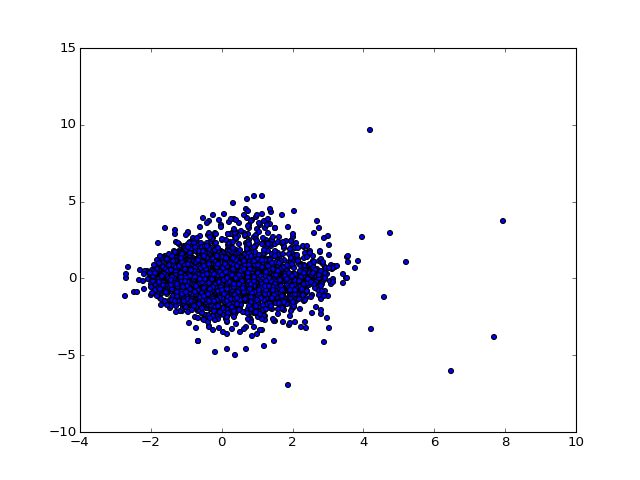

In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.scatter(pca_Legendres[:,0],pca_Legendres[:,1])

##PCA Scatterplot of first and second principle components (dots are polynomials)

In [19]:
from sklearn.cluster import KMeans


cluster = KMeans(n_clusters=7)

cluster.fit(scaledLstack)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [20]:
cluster.cluster_centers_

array([[ 0.46879665,  0.62945456,  0.91436923, -0.65088854, -1.54430217],
       [-0.99942482,  0.13915017,  0.52435906, -0.2649289 ,  0.53345325],
       [-0.35751911, -0.70231708,  0.62481249,  0.85078904, -0.36853332],
       [ 1.67495683,  0.2210061 , -0.72414003,  0.4880234 , -0.88030514],
       [ 0.4073503 ,  1.47098225, -1.10010972, -0.82277401,  1.0670748 ],
       [ 0.13817332, -1.01469628, -1.09717861,  0.93962595,  0.83199084],
       [ 0.11281154, -0.14860707, -0.09775156, -0.43051065, -0.07585267]])

<IPython.core.display.Javascript object>


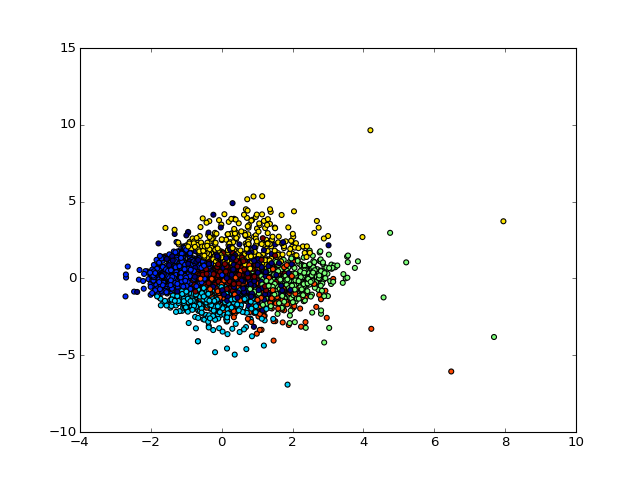

In [21]:
plt.figure()
plt.scatter(pca_Legendres[:,0],pca_Legendres[:,1], c=cluster.labels_)

In [22]:
speaker_ipu_histograms = []
for speaker in all_ipu_coefs:
    scaled_ipu = scaler.transform(speaker)
    ipu_centers = cluster.predict(scaled_ipu)
    histo = np.bincount(ipu_centers, minlength=cluster.n_clusters) #set to to the clusteres we specificied before 
    speaker_ipu_histograms.append(histo / float(histo.sum()))

<IPython.core.display.Javascript object>


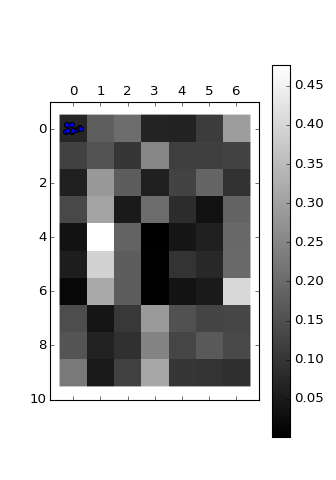

<matplotlib.colorbar.Colorbar instance at 0x107D63C8>

In [23]:
speaker_ipu_histograms

plt.matshow(speaker_ipu_histograms,cmap="gray")
plt.colorbar()
#cmap="viridis"

<IPython.core.display.Javascript object>


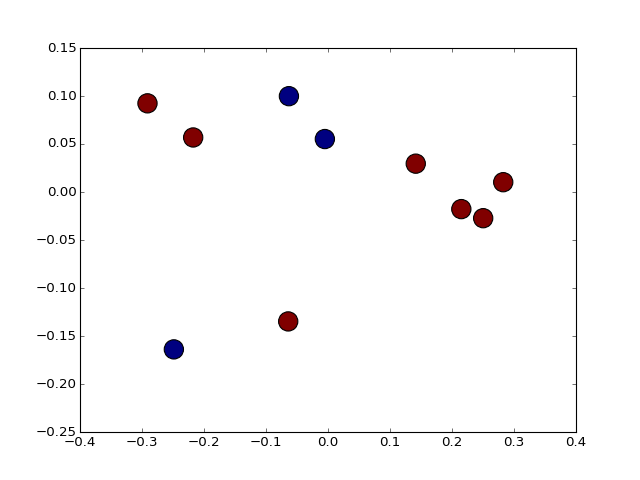

In [59]:
pca = PCA(n_components =2)
pca.fit(speaker_ipu_histograms)
pca_Histograms = pca.transform(speaker_ipu_histograms)
plt.figure()
plt.scatter(pca_Histograms[:,0],pca_Histograms[:,1], c=np.array(label_list)=="Mandarin", s=300)



In [56]:
np.array(label_list) == "Mandarin"

array([ True,  True, False, False,  True,  True, False,  True,  True,  True], dtype=bool)

## Dataframes get made below.  Make polynomial coefficient features above here!

In [30]:
### This is where you will make your dataframes 
import pandas as pd
print syl_per_speaker 
print minf0_per_speaker
print maxF0_per_speaker
print meanf0_per_speaker
print meanStd_per_speaker
print meanZnorm_per_speaker
print whispers_per_speaker

### put all in numpy array, then run standard scaler over the whole thing ###
######use standard scaler to rescale this data here (each list), and then put into a dataframe######

[3.296326108595352, 3.3932327495261725, 3.910851440786691, 5.223295886002508, 3.6591868881314786, 4.661195324090227, 3.9716189630721312, 3.708666520987404, 4.295169521507162, 4.230347083347124]
[3.9771397628278025, 1.7014789682383724, 3.9819990157088103, 4.01563925629443, 3.9777760559076736, 1.5056221402338008, 3.977010082031824, 3.9840566896282157, 1.7082207522150528, 3.9781887438756485]
[6.2936004499773235, 6.299180233754941, 5.799942993429458, 6.026144647462959, 6.30460533920825, 6.302101719953073, 6.281448883696522, 6.284702674008171, 6.295900813273147, 6.305790786577447]
[0.22995022533016798, 0.1590091546696891, 0.14459972340881, 0.10263574910219019, 0.14070726347417614, 0.13121121801649052, 0.10875342690959565, 0.16957734688166995, 0.22636704531651272, 0.21018597092139246]
[4.594745193716154, 4.746273388368734, 4.291474539717812, 4.60126640835742, 4.34018318985011, 4.023768022086238, 4.404162055052157, 5.120752876477532, 5.106732995543153, 5.062279375582871]
[-0.1583772754981301,

In [31]:
import pandas as pd
import re

features = pd.DataFrame(syl_per_speaker, columns=["Syl_Per_Speaker"])
features["minF0"] = minf0_per_speaker
features["maxF0"]=maxF0_per_speaker
features["meanF0"] = meanf0_per_speaker
features["meanStd"] = meanStd_per_speaker
features["meanZnorm"] = meanZnorm_per_speaker
features["Total_Whispered"] = whispers_per_speaker

print features


   Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  meanZnorm  \
0         3.296326  3.977140  6.293600  0.229950  4.594745  -0.158377   
1         3.393233  1.701479  6.299180  0.159009  4.746273  -0.236796   
2         3.910851  3.981999  5.799943  0.144600  4.291475  -0.279060   
3         5.223296  4.015639  6.026145  0.102636  4.601266   0.032541   
4         3.659187  3.977776  6.304605  0.140707  4.340183   0.464780   
5         4.661195  1.505622  6.302102  0.131211  4.023768   0.150829   
6         3.971619  3.977010  6.281449  0.108753  4.404162  -0.148043   
7         3.708667  3.984057  6.284703  0.169577  5.120753  -0.724409   
8         4.295170  1.708221  6.295901  0.226367  5.106733   0.301269   
9         4.230347  3.978189  6.305791  0.210186  5.062279   0.184372   

   Total_Whispered  
0               28  
1               44  
2                8  
3                6  
4               35  
5               70  
6                6  
7                5  
8      

In [ ]:
########pass on this for now, do it in the next cell ##############

label_csv = pd.read_csv("c:/Python27/qp2_py/labels/Participants_info_200-563.csv")
small_test =  label_csv[4:8]

print small_test
small_labels = small_test["Language"]


features["labels"] = small_labels



In [32]:
#### Creates CSV dataframe, gets all text grid and wav files names
label_csv = pd.read_csv("c:/Python27/qp2_py/labels/Participants_info_200-563.csv")
path = "c:/Python27/qp2_py/wav_baseline/"
allFiles = os.listdir(path)
allTxtgridsCOMB = [item for item in allFiles if item[0]== "C"]
allWavs = [item for item in allFiles if item[0] !="C"]

allTxtgrids = []
for item in allTxtgridsCOMB:
    outlist = item.split('COMBINE_')
    name = outlist[1]
    allTxtgrids.append(name)

    
allTxtgrids.sort()
allWavs.sort()


wavBaseline = []
for item in allWavs:
    if re.search('.*-baseline_.*', item):
        wavBaseline.append(item)

### Makes a list of tuples (IDnum, channel number they have)
IDs = []
for item in wavBaseline:
    searched = re.search('p(\d.*)-', item)
    outnum = searched.group(1)
    ch_searched = re.search('.*_(ch\d).*', item)
    channel = ch_searched.group(1)
    entry = (outnum, channel)
    IDs.append(entry)


## Puts tuples (ID, channel) into the label dataframe
id_channels = []
for i in range(len(label_csv['PID'])):
    ID = label_csv['PID'][i]
    for item in IDs:
        if int(item[0]) == ID:
            Found = item
            break
        else:
            Found = False
    if Found:
        id_channels.append(Found)
    else:
        id_channels.append("NA")
        
label_csv["ID_Channels"] =  id_channels 
print label_csv

     PID  Group   Gender  Language ID_Channels
0    200     55   Female  Mandarin          NA
1    201     55   Female   English          NA
2    202     56   Female   English          NA
3    203     56   Female   English          NA
4    204     57   Female  Mandarin  (204, ch2)
5    205     57     Male  Mandarin  (205, ch1)
6    206     58   Female   English  (206, ch2)
7    207     58     Male   English  (207, ch1)
8    208     59     Male  Mandarin  (208, ch2)
9    209     59     Male  Mandarin  (209, ch1)
10   210     60     Male  Mandarin  (210, ch2)
11   211     60   Female   English  (211, ch1)
12   212     61   Female  Mandarin  (212, ch2)
13   213     61   Female   English  (213, ch1)
14   214    NaN      NaN       NaN          NA
15   215    NaN      NaN       NaN          NA
16   216     62   Female   English  (216, ch2)
17   217     62   Female  Mandarin  (217, ch1)
18   218    NaN     Male       NaN          NA
19   219    NaN      NaN       NaN          NA
20   220     

In [33]:
data_path = "c:/Python27/qp2_py/small_for_test/"
allFiles = os.listdir(data_path)
allCurrentWavs = [item for item in allFiles if item[0] !="C"]

#print allCurrentWavs

small_test =  label_csv[4:10]


add1 = label_csv.loc[65]
add2 = label_csv.loc[186]
add3 = label_csv.loc[217]
add4 = label_csv.loc[216]


small_test = small_test.append(add1)
small_test = small_test.append(add2)
small_test = small_test.append(add3)
small_test = small_test.append(add4)
#print small_test

label_list = []
x = small_test["Language"]
for i in x:
    label_list.append(i)

print label_list
features["labels"] = label_list


['Mandarin', 'Mandarin', 'English', 'English', 'Mandarin', 'Mandarin', 'English', 'Mandarin', 'Mandarin', 'Mandarin']


In [34]:
print features

   Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  meanZnorm  \
0         3.296326  3.977140  6.293600  0.229950  4.594745  -0.158377   
1         3.393233  1.701479  6.299180  0.159009  4.746273  -0.236796   
2         3.910851  3.981999  5.799943  0.144600  4.291475  -0.279060   
3         5.223296  4.015639  6.026145  0.102636  4.601266   0.032541   
4         3.659187  3.977776  6.304605  0.140707  4.340183   0.464780   
5         4.661195  1.505622  6.302102  0.131211  4.023768   0.150829   
6         3.971619  3.977010  6.281449  0.108753  4.404162  -0.148043   
7         3.708667  3.984057  6.284703  0.169577  5.120753  -0.724409   
8         4.295170  1.708221  6.295901  0.226367  5.106733   0.301269   
9         4.230347  3.978189  6.305791  0.210186  5.062279   0.184372   

   Total_Whispered    labels  
0               28  Mandarin  
1               44  Mandarin  
2                8   English  
3                6   English  
4               35  Mandarin  
5         

In [44]:
legendre_features = pd.concat([features,pd.DataFrame(speaker_ipu_histograms, columns=["cluster%d" % i for i in range(7)])], axis=1)

In [45]:
feature_columns = [col for col in list(legendre_features.columns) if col!= "labels"]
x_train =(legendre_features[feature_columns])
X_train= x_train[:5]
X_test = x_train[5:10]


y_train = label_list[:5]
y_test = label_list[5:10]

print X_train, y_train, X_test, y_test




   Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  meanZnorm  \
0         3.296326  3.977140  6.293600  0.229950  4.594745  -0.158377   
1         3.393233  1.701479  6.299180  0.159009  4.746273  -0.236796   
2         3.910851  3.981999  5.799943  0.144600  4.291475  -0.279060   
3         5.223296  4.015639  6.026145  0.102636  4.601266   0.032541   
4         3.659187  3.977776  6.304605  0.140707  4.340183   0.464780   

   Total_Whispered  cluster0  cluster1  cluster2  cluster3  cluster4  \
0               28  0.072855  0.177438  0.204465  0.069330  0.065805   
1               44  0.124654  0.156510  0.102493  0.250693  0.119114   
2                8  0.063492  0.285714  0.174603  0.063492  0.126984   
3                6  0.135593  0.305085  0.050847  0.203390  0.084746   
4               35  0.035768  0.476900  0.186289  0.001490  0.041729   

   cluster5  cluster6  
0  0.116334  0.293772  
1  0.119114  0.127424  
2  0.190476  0.095238  
3  0.033898  0.186441  
4  0.062

In [49]:
from sklearn import  svm
classifier = svm.LinearSVC(C=100)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)
#classifier.predict(X_test)


0.40000000000000002

In [50]:
classifier.predict(X_test), y_test

(array(['Mandarin', 'English', 'English', 'English', 'English'], 
       dtype='|S8'),
 ['Mandarin', 'English', 'Mandarin', 'Mandarin', 'Mandarin'])

In [ ]:
listy = label_csv['ID_Channels']
print len(listy)

In [ ]:
## 4/6 /let's try this again

baseline_files = []
part1 = []
part2 = []

missingb = []
missing = 0

for item in allWavs:
    fname = item
    searched = re.search('.*_(ch\d).*', item)
    channel = searched.group(1)
    if re.search("p(\d+)p(\d+)-(.*)_(ch\d)", item):
        nonBases = re.search("p(\d+)p(\d+)-(.*)_(ch\d)", item)
        id1, id2, part, testchan = nonBases.group(1), nonBases.group(2), nonBases.group(3), nonBases.group(4)
        #print id1, id2, part, testchan
        baseline = False
        trainf = True
    
    elif re.search('p(\d+).*', item):
        base = re.search('p(\d+).*', item)
        id1 = base.group(1)
        baseline = True
        trainf = False
        #print id1
    

    if baseline == True:
        #print baseline, fname
        for element in label_csv["ID_Channels"]:
            if type(element)== str:
                fname = "NA"
                pass
            elif type(element) == tuple:
                ID = element[0]
                chan = element[1]
                if id1 == ID:
                    print fname
    else:
        print "FALSE"


            
        #compare id1

print len(baseline_files)

    


In [ ]:
##print allWavs[:10]

###### NONE OF THIS WORKS AS OF 3/29/16

### Code that makes lists that correspond with the dataframe for baseline, part1, and part2s
baseline = []
part1 = []
part2 = []
count = 0

for i in range(len(label_csv['ID_Channels'])):
    tup = label_csv['ID_Channels'][i]
    #print tup
    if type(tup) == tuple:
        ID = tup[0]
        ch = tup[1]

        for item in allWavs:
            baseline_file = False
            searched = re.search('.*_(ch\d).*', item)
            channel = searched.group(1)
            if re.search("p(\d+)p(\d+)-(.*)_(ch\d)", item):
                nonBases = re.search("p(\d+)p(\d+)-(.*)_(ch\d)", item)
                id1, id2, part, testchan = nonBases.group(1), nonBases.group(2), nonBases.group(3), nonBases.group(4)
                #print id1, id2, part, testchan
                nonbaseFound = True
                baseFound = False
                #print item, baseFound, nonbaseFound




            elif re.search('p(\d+).*', item):
                base = re.search('p(\d+).*', item)
                id1 = base.group(1)
                baseFound = True
                nonbaseFound = False
                #print item, baseFound, nonbaseFound



              
            if nonbaseFound == True:
                if ch== testchan:
                    if ID == id1 or ID == id2:
                        nonbaseFound = True
                        part = part
                        break
                else:
                    nonbaseFound = False
                    break


        #print baseFound, nonbaseFound, ID, part
        #print "here"
        print baseFound, nonbaseFound, item
        if baseFound == False and nonbaseFound == False:
            entry = "NA"
            baseline.append(entry)
            part1.append(entry)
            part2.append(entry)
            test = 1
            print test            
            
        elif baseFound == False and nonbaseFound == True:
            entry = item
            empty = "NA"
            if part[-1] == 1:
                baseline.append(empty)
                part1.append(entry)
                part2.append(empty)
                test = 3
                print test
            elif part[-1] == 2:
                baseline.append(empty)
                part1.append(empty)
                part2.append(entry)
                test=4
                print test
                        
            
        elif baseFound == True and nonbaseFound == False:
            entry = item
            empty = "NA"
            baseline.append(entry)
            part1.append(empty)
            part2.append(empty)
            test = 2
            print test
        

    else:
        baseline.append("NA")
        part1.append("NA")
        part2.append("NA")
        test = 5
        print test
    count = count+1
    #print count
    print len(baseline), len(part1)


            
 

#print len(baseline)
#print len(part1)
#print len(part2)



In [ ]:
label_csv["baselineFiles"] = baseline
print label_csv